# Exploration

In [1]:
import regex
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## Load the data

We load the training and validation set, and we start exploring

In [2]:
training_set = pd.read_csv("stack_overflow_questions_train.csv")
val_set = pd.read_csv("stack_overflow_questions_valid.csv")
texts = training_set["Body"]
text_lengths = texts.map(len)
tag_regex = regex.compile(r"<(.*?)>")

## Plot the lengths

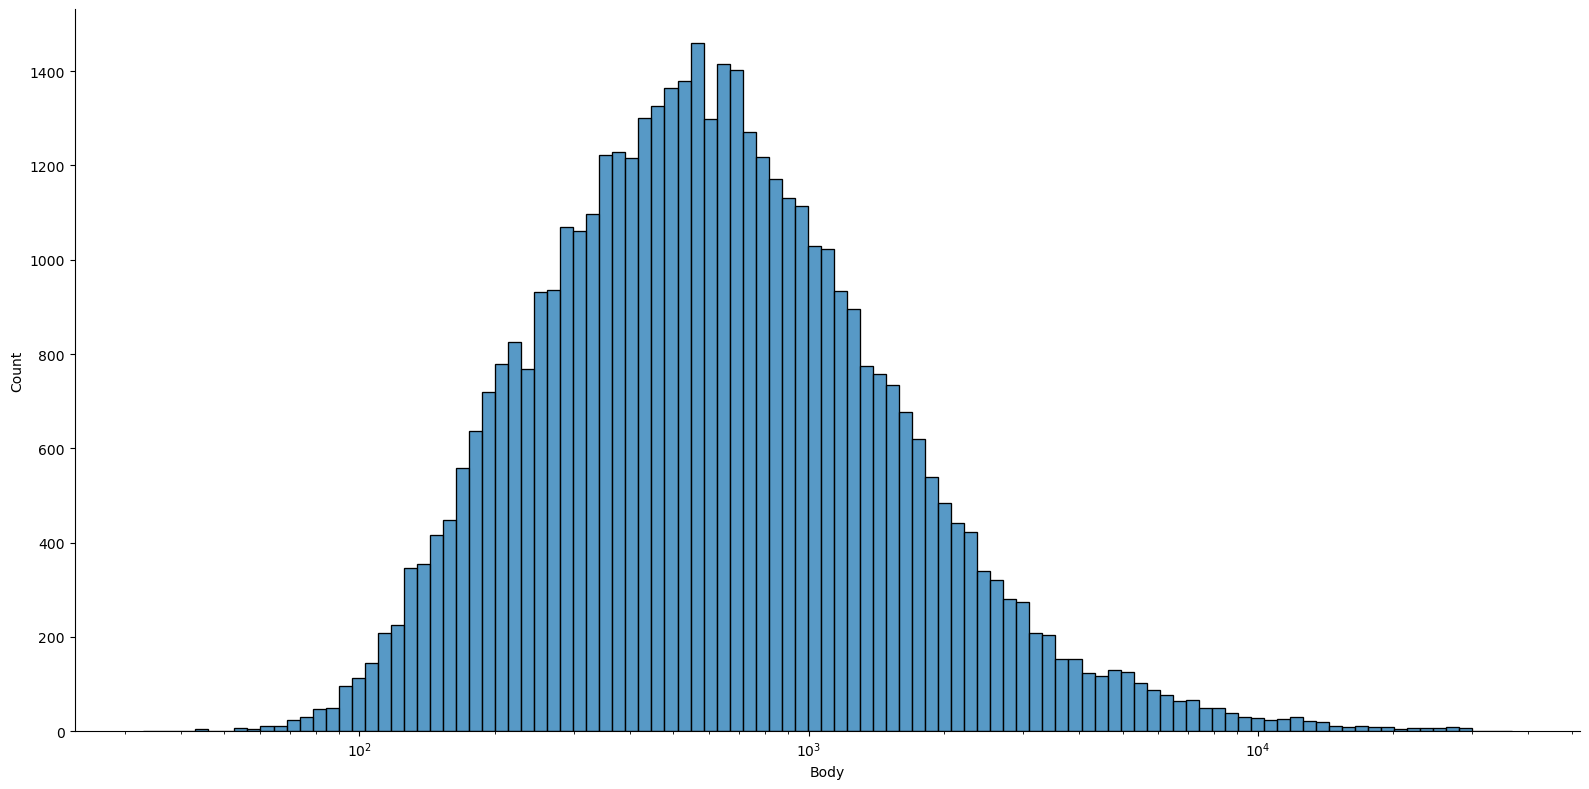

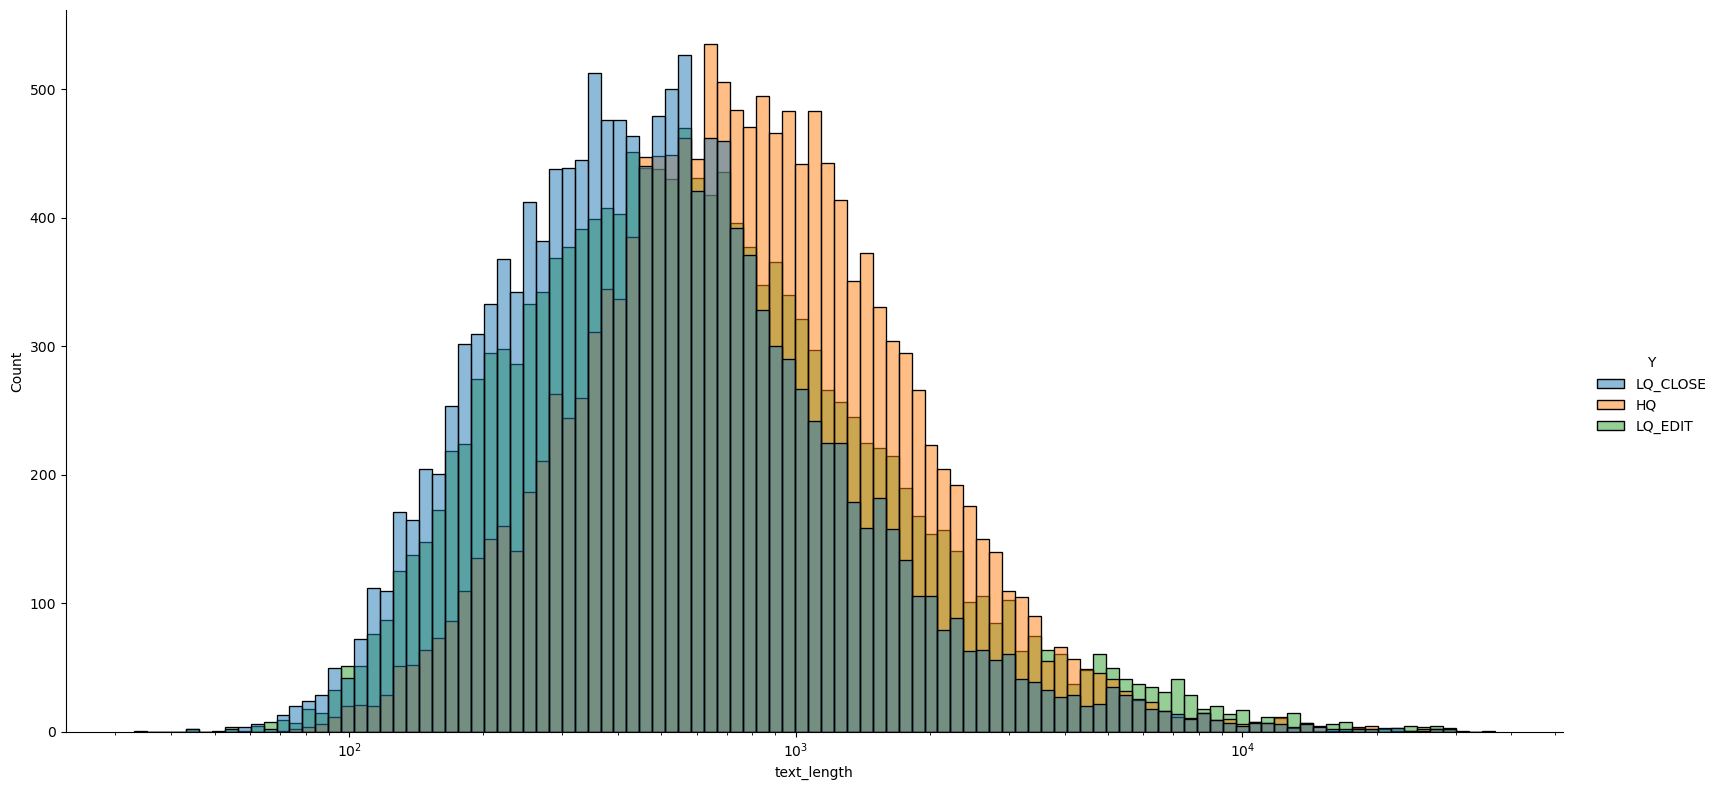

In [3]:
sns.displot(texts.map(len), log_scale=True, height=8, aspect=2)
training_set["text_length"] = text_lengths = texts.map(len)
sns.displot(x="text_length", data=training_set, hue="Y", log_scale=True, height=8, aspect=2);

Length seem to have a substantial impact on the target variable, with the average LQ post being shorter than the average HQ post, but the HQ length distribution is more concentrated around the mean and has a shorter tail than LQ posts. 

So to sum up: **very short and very long documents are likely to be garbage.**

## Explore tags

Like many other language related data, the tag distribution follow a Zipfian law, meaning that taking the loglog plot of Frequency against Rank lead to a nice straight line.

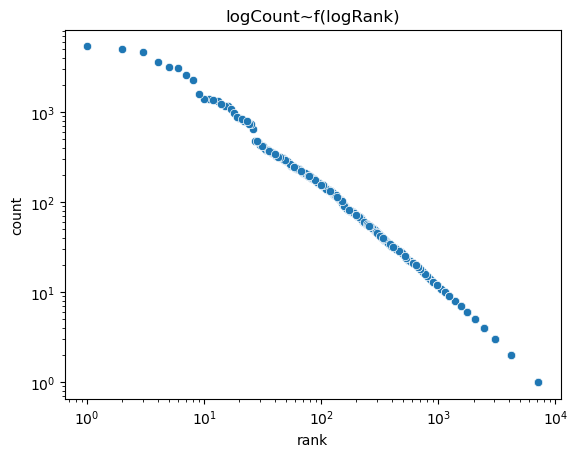

In [4]:
def get_tag_counts(tags):
    counter = Counter()
    for _tags in tags.map(tag_regex.findall):
        counter.update(_tags)
    return (
        pd.Series(counter)
        .rename("count")
        .to_frame()
        .assign(rank=lambda df: (-df["count"]).rank())
    )

sns.scatterplot(get_tag_counts(training_set["Tags"]), x="rank", y="count")
plt.gca().set(xscale="log", yscale="log", title="logCount~f(logRank)");

The graph below shows the difference in use of tags for each target class. More importantly, we see that the HQ category seem to be separable from the other two, but differentiating between the two LQ classes is going to be difficult.

To create the graph, we will plot the logFrequencies ranked according to each ranking. If two samples are drawned from the same distribution, they should align perfectly on the same line. If two samples are drawned from dissimilar distributions, the dots from the outsider are going to be dispersed far to the line of the true ranking. This is the case in the left plot: The blue dots and the green dots are well-grouped along the line, and orange dots are all over the place. This is also very visible in the second plot. 

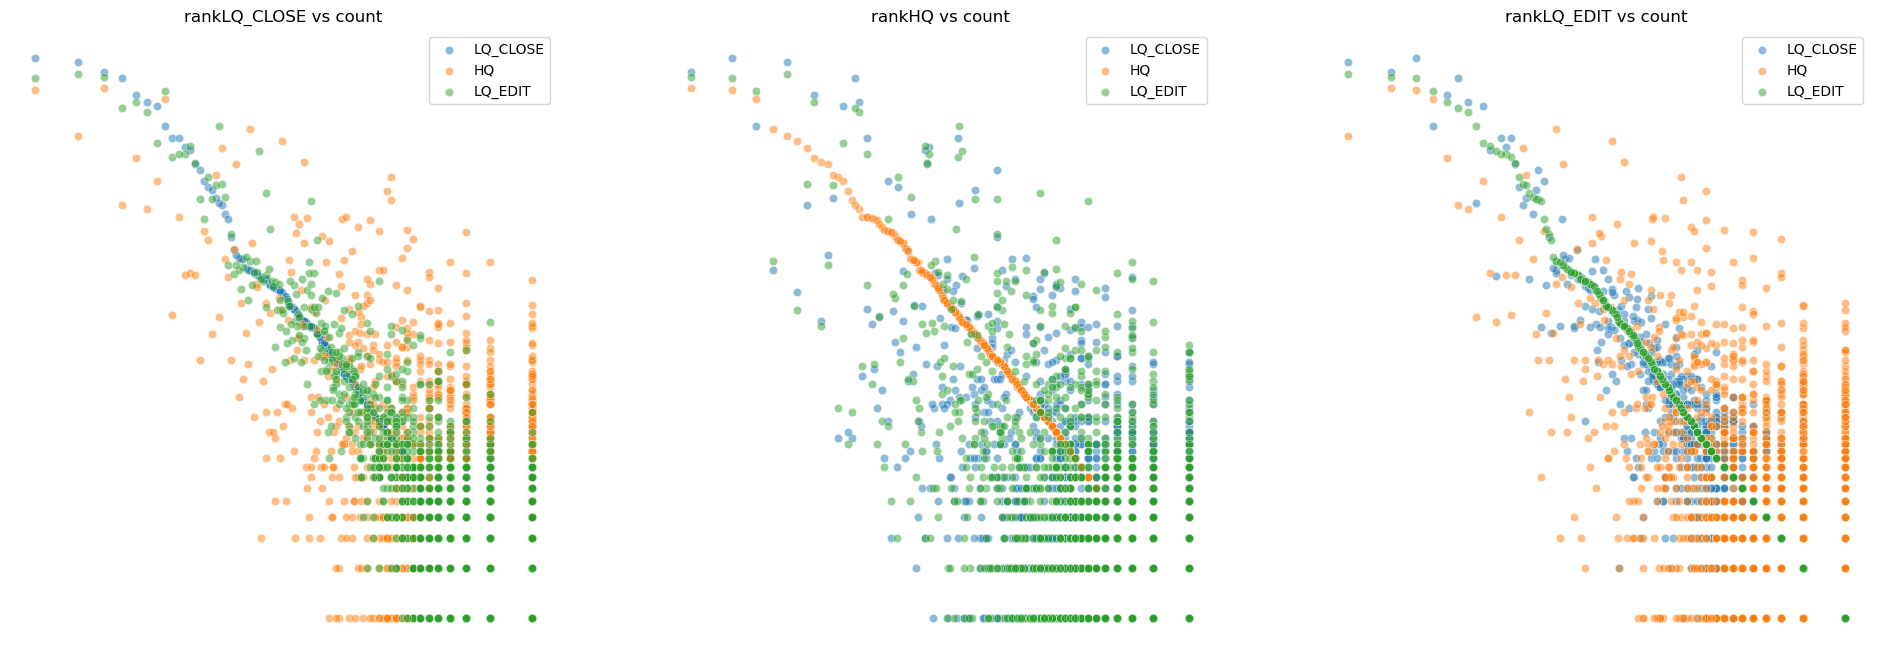

In [5]:
tag_counts = pd.concat({label: get_tag_counts(group) for label, group in training_set["Tags"].groupby(training_set["Y"])}, axis=0)

fig, axs = plt.subplots(1, 3, figsize=(24,8))
plot_data = tag_counts.unstack(level=0)
for rank, ax in zip(training_set["Y"].unique(), axs):
    for count in training_set["Y"].unique():
        ax = sns.scatterplot(plot_data, x=("rank", rank), y=("count", count), ax=ax, label=count, alpha=.5)
    ax.set(xscale="log", yscale="log", ylabel="count", title=f"rank{rank} vs count")
    ax.axis("off")

There is a clear difference in tag frequency distributions between HQ and LQ. Both LQ classes seem to be more consistent with one another. 

To take advantage of that, we will build a very simple classifier which will receive a vector as input of dimension `|UniqueTags|` and predicts the post quality. 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass, Field
from sklearn.metrics import f1_score, classification_report
from typing import Literal
    
    
class TagSequenceClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, X):
        return self.fc2(F.relu(self.fc1(X.float())))


@dataclass
class TrainerConfig:
    
    num_epochs: int = 10
    batch_size: int = 32
    eval_batch_size: int = 64
    learning_rate: float = 1e-3
    device: Literal["cuda", "cpu"] = "cpu"

    @property
    def train_config(self):
        return {
            "num_epochs": self.num_epochs, 
            "batch_size": self.batch_size,
            "eval_batch_size": self.eval_batch_size,
            "learning_rate": self.learning_rate, 
            "device": self.device
        }
        
class Trainer:
    
    def __init__(self, model, config, data_collator=None):
        self.num_epochs = config.num_epochs
        self.batch_size = config.batch_size
        self.eval_batch_size = config.eval_batch_size
        self.learning_rate = config.learning_rate
        self.device = torch.device(config.device)
        self.model = model
        self.data_collator = data_collator

    @property
    def optimizer(self):
        if not hasattr(self, "_optimizer"):
            raise TypeError("optimizer not set")
        return self._optimizer

    @optimizer.setter
    def optimizer(self, _optimizer):
        self._optimizer = _optimizer
        
    def train(self, train_set, test_set):
        
        self.model.train()
        N = self.num_epochs
        model = self.model
        model.to(self.device)
        model_params = filter(lambda p: p.requires_grad, model.parameters())
        optimizer = self.optimizer = optim.AdamW(model_params, lr=self.learning_rate)
        lr_scheduler = optim.lr_scheduler.LinearLR(
            optimizer, start_factor=1., end_factor=.1, total_iters=N
        )
        
        for epoch in range(N):
            train_loss = self.train_one_epoch(train_set)
            metrics = self.evaluate(test_set)
            metrics = {
                "train_loss": f"{train_loss:.3f}", 
                **{f"eval_{k}": f"{x:.3f}" for k, x in metrics.items()}, 
                "lr": f"{lr_scheduler.get_last_lr()[0]:.0e}"
            }
            print(f"{epoch+1}/{N} " + " ".join(map("{0[0]}={0[1]}".format, metrics.items())))
            lr_scheduler.step()

    def train_one_epoch(self, dataset):
        loss = 0
        num_samples = 0
        dataloader = DataLoader(dataset, batch_size=self.batch_size, collate_fn=self.data_collator)
        for batch in dataloader:
            loss += self.train_one_step(recursive_to(batch, self.device))
        return loss / len(dataset)
            
    def train_one_step(self, batch):
        self.optimizer.zero_grad()
        if isinstance(batch, dict):
            y = batch.pop("labels")
            logits = self.model(**batch)
        else:
            X, y = batch
            logits = self.model(X)            
        loss = F.cross_entropy(logits, y, reduction='sum')
        loss.backward()
        self.optimizer.step()
        return loss.item()

    @torch.no_grad()
    def evaluate(self, dataset):
        self.model.eval()
        self.model.to(self.device)
        loss = 0
        num_samples = 0
        y_true, y_pred = [], []
        dataloader = DataLoader(dataset, batch_size=self.eval_batch_size, collate_fn=self.data_collator)
        for batch in dataloader:
            batch = recursive_to(batch, self.device)
            if isinstance(batch, dict):
                y = batch.pop("labels")
                logits = self.model(**batch)
            else:
                X, y = batch
                logits = self.model(X)
                
            y_true.extend(y.tolist())
            
            y_pred.extend(logits.argmax(-1).cpu())
            loss += F.cross_entropy(logits, y.to(self.device), reduction="sum").cpu().item()
            
        y_true, y_pred = np.array(y_true), np.array(y_pred)
            
        metrics = {
            "loss": loss / len(dataset),
            "acc": (y_true == y_pred).mean(),
            "f1": f1_score(y_true, y_pred, average="macro")
        }
        self.model.train()
        return metrics

    @torch.no_grad()
    def predict(self, dataset, batch_size=64):
        self.model.eval()
        self.model.to(self.device)
        y_pred = []
        dataloader = DataLoader(dataset, batch_size=self.eval_batch_size, collate_fn=self.data_collator)
        for batch in dataloader:
            batch = recursive_to(batch, self.device)
            if isinstance(batch, dict):
                batch.pop("labels")
                logits = self.model(**batch)
            else:
                
                logits = self.model(batch[0])
                
            y_pred.extend(logits.argmax(-1).cpu())
        self.model.train()
        return np.array(y_pred)

    
def recursive_to(x, target: torch.device):
    if isinstance(x, dict):
        return {k: recursive_to(v, target) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(target)
    elif isinstance(x, list):
        return [recursive_to(i, target) for i in x]
    else:
        return x

In [7]:
from datasets import load_dataset, DatasetDict
from torch.utils.data import TensorDataset

tag_encoder = CountVectorizer(analyzer=tag_regex.findall).fit(training_set["Tags"])
target_encoder = LabelEncoder().fit(training_set["Y"])   

X_train, X_val = (tag_encoder.transform(ds["Tags"]).toarray() for ds in (training_set, val_set))
y_train, y_val = (target_encoder.transform(ds["Y"]) for ds in (training_set, val_set))

tag_datasets = {
    "train": TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    "validation": TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
}

/home/quent/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
simple_conf = dict(input_dim=len(tag_encoder.vocabulary_), hidden_dim=32, output_dim=3)
trainer_conf = TrainerConfig(num_epochs=10, batch_size=128, learning_rate=7e-4, device="cuda")
tag_model = TagSequenceClassifier(**simple_conf)
trainer = Trainer(tag_model, trainer_conf)
trainer.train(tag_datasets["train"], tag_datasets["validation"])
torch.save(tag_model, "tag_model.pt")

print()
print(classification_report(
    trainer.predict(TensorDataset(torch.from_numpy(X_val))), y_val, 
    target_names=target_encoder.classes_
))

1/10 train_loss=0.945 eval_loss=0.948 eval_acc=0.538 eval_f1=0.518 lr=7e-04
2/10 train_loss=0.803 eval_loss=0.902 eval_acc=0.572 eval_f1=0.564 lr=6e-04
3/10 train_loss=0.757 eval_loss=0.885 eval_acc=0.586 eval_f1=0.582 lr=6e-04
4/10 train_loss=0.729 eval_loss=0.875 eval_acc=0.593 eval_f1=0.593 lr=5e-04
5/10 train_loss=0.710 eval_loss=0.865 eval_acc=0.599 eval_f1=0.600 lr=4e-04
6/10 train_loss=0.695 eval_loss=0.855 eval_acc=0.604 eval_f1=0.606 lr=4e-04
7/10 train_loss=0.684 eval_loss=0.845 eval_acc=0.607 eval_f1=0.609 lr=3e-04
8/10 train_loss=0.677 eval_loss=0.834 eval_acc=0.610 eval_f1=0.613 lr=3e-04
9/10 train_loss=0.671 eval_loss=0.824 eval_acc=0.617 eval_f1=0.619 lr=2e-04
10/10 train_loss=0.666 eval_loss=0.816 eval_acc=0.620 eval_f1=0.621 lr=1e-04

              precision    recall  f1-score   support

          HQ       0.73      0.80      0.77      4549
    LQ_CLOSE       0.66      0.53      0.59      6165
     LQ_EDIT       0.47      0.55      0.51      4286

    accuracy        

## Results of Tag model

We get an accuracy of 62% on the validation set. As expected, we have a better performance on the HQ class.

## Title classification

Already from the titles, we can try to classify the data. For this, we will combine RoBERTa-large (a bidirectional transformer) with a specific head for sequence classification. We train the model in two steps:
 - First one epoch with the encoder frozen to bring the new parameters to level
 - Then two epochs at a low learning rate to finetune the whole model
 
 We do that with the script `run_classification.py`.
 
 This gives us a final accuracy of **59.67%** after training and **68.28%** after finetuning.
 
 Most confusion is between `LQ_CLOSE` and `LQ_EDIT`, `HQ` is far ahead in f1-score.

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, default_data_collator
from datasets import load_dataset

class HFModelWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model
        
    def forward(self, *args, **kwargs):
        out = self.hf_model.forward(*args, **kwargs)
        return out.logits


# Load the data HF style
title_datasets = load_dataset("csv", data_files={
#     "train": "stack_overflow_questions_train.csv", 
    "validation": "stack_overflow_questions_valid.csv"
})

title_model = AutoModelForSequenceClassification.from_pretrained("roberta-title-results/finetune")
tokenizer = AutoTokenizer.from_pretrained("roberta-title-results/finetune")
label2id = title_model.config.label2id

def preprocess(examples):
    batch = tokenizer(examples["Title"], padding="max_length", max_length=128, truncation=True)
    batch["labels"] = [label2id[y] for y in examples["Y"]]
    return batch

title_datasets["validation"] = title_datasets["validation"].map(
    preprocess, 
    batched=True, 
    remove_columns=title_datasets["validation"].features
)

title_preds = Trainer(
    HFModelWrapper(title_model), 
    TrainerConfig(eval_batch_size=128, device="cuda"),
    data_collator=default_data_collator
).predict(title_datasets["validation"])

print(classification_report(
    title_datasets["validation"]["labels"], title_preds,
    target_names=list(label2id)
))

              precision    recall  f1-score   support

          HQ       0.77      0.83      0.80      5000
    LQ_CLOSE       0.59      0.67      0.63      5000
     LQ_EDIT       0.70      0.54      0.61      5000

    accuracy                           0.68     15000
   macro avg       0.69      0.68      0.68     15000
weighted avg       0.69      0.68      0.68     15000



<Axes: >

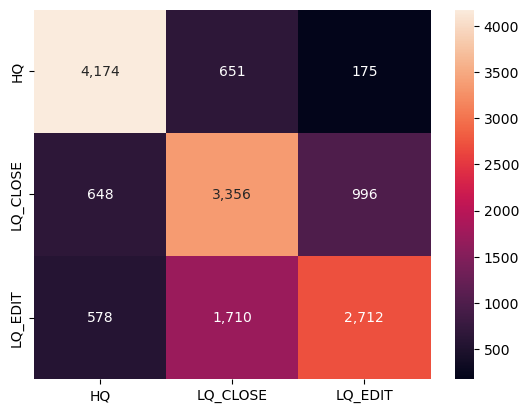

In [12]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    confusion_matrix(title_datasets["validation"]["labels"], title_preds),
    annot=True, fmt=",d", 
    xticklabels=list(label2id), 
    yticklabels=list(label2id)
)

# Combined models

In [13]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, default_data_collator


class CombinedModel(nn.Module):
    
    def __init__(self, title_model, tag_model, weights=(0.5, 0.5)):
        super().__init__()
        self.title_model = title_model
        self.tag_model = tag_model
        self.output_dim = self.tag_model.output_dim
        self.weights = nn.Parameter(torch.tensor(weights))

    def forward(self, input_ids, tags, input_lengths=None, attention_mask=None):
        title_pred = self.title_model(input_ids, attention_mask=attention_mask).logits
        tag_pred = self.tag_model(tags)
        combined_pred = torch.stack([title_pred, tag_pred], dim=1).softmax(-1)
        return (combined_pred * self.weights.unsqueeze(-1)).sum(1)

    
def freeze_modules(model, pattern):
    rgx = regex.compile(pattern)
    for name, param in model.named_parameters():
        if rgx.search(name):
            param.requires_grad = False      


def make_preprocess_function(tokenizer, tag_encoder, target_encoder):
    
    def preprocess(examples):
        batch = tokenizer(examples["Title"], padding="max_length", max_length=128, truncation=True)
        batch["tags"] = tag_encoder.transform(examples["Tags"]).toarray()
        batch["labels"] = target_encoder.transform(examples["Y"])
        return batch
    
    return preprocess

In [18]:
title_model = AutoModelForSequenceClassification.from_pretrained("roberta-title-results/finetune")
tokenizer = AutoTokenizer.from_pretrained("roberta-title-results/finetune")
combined_datasets = load_dataset("csv", data_files={
#     "train": "stack_overflow_questions_train.csv", 
    "validation": "stack_overflow_questions_valid.csv"
})

combined_datasets = combined_datasets.map(
    make_preprocess_function(tokenizer, tag_encoder, target_encoder),
    batched=True,
    desc="Running tokenizer on dataset",
    remove_columns=next(iter(combined_datasets.values())).features
)

combined_model = CombinedModel(title_model, tag_model)
combined_preds = Trainer(
    combined_model, 
    TrainerConfig(eval_batch_size=128, device="cuda"), 
    data_collator=default_data_collator
).predict(combined_datasets["validation"])

print(classification_report(
    combined_datasets["validation"]["labels"], 
    combined_preds, 
    target_names=list(label2id)
))

Running tokenizer on dataset: 100%|█| 15000/15000 [00:02<00:00, 7358.16 examples


              precision    recall  f1-score   support

          HQ       0.81      0.85      0.83      5000
    LQ_CLOSE       0.61      0.70      0.65      5000
     LQ_EDIT       0.70      0.57      0.63      5000

    accuracy                           0.71     15000
   macro avg       0.71      0.71      0.70     15000
weighted avg       0.71      0.71      0.70     15000



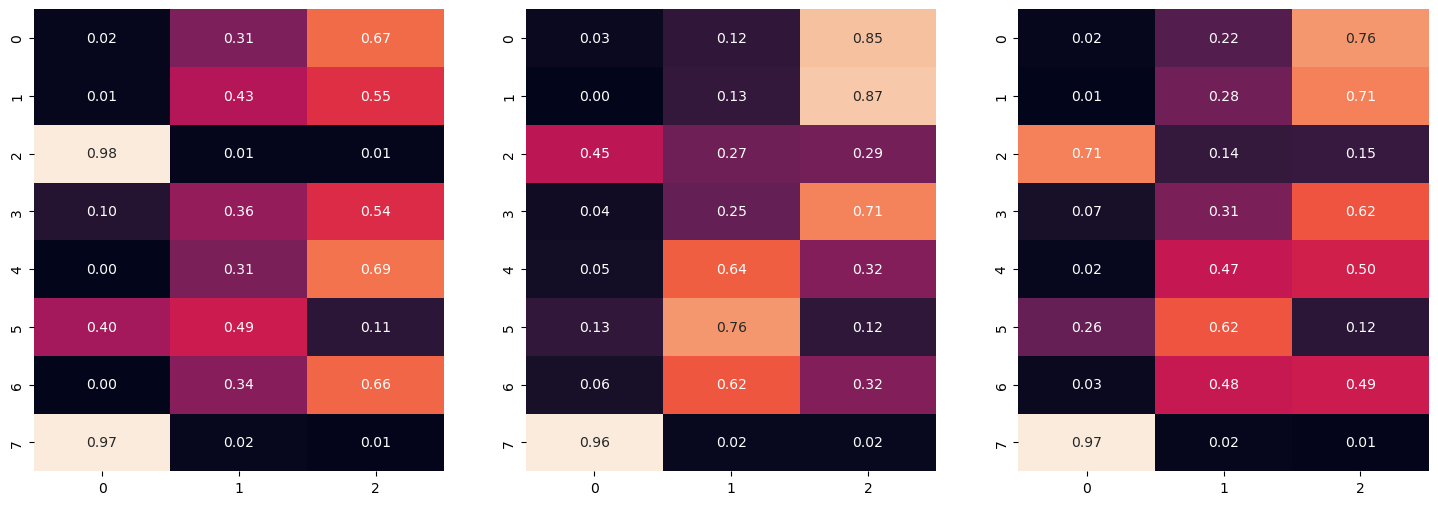

In [21]:
combined_model = CombinedModel(title_model, tag_model).cuda()

batch = next(iter(DataLoader(combined_datasets["validation"], 8, collate_fn=default_data_collator)))
batch = recursive_to(batch, torch.device("cuda"))
with torch.no_grad():
    logits_tags = combined_model.tag_model(batch["tags"])
    logits_title = combined_model.title_model(batch["input_ids"], attention_mask=batch["attention_mask"]).logits
    combined_scores = torch.stack([logits_title, logits_tags], dim=1).softmax(-1)
    title_scores, tag_scores = combined_scores[:, 0], combined_scores[:, 1]
    combined_scores = (combined_scores * combined_model.weights.unsqueeze(-1)).sum(1)
    
fig, axs = plt.subplots(1, 3, figsize=(18,6))
for scores, ax in zip(recursive_to([title_scores, tag_scores, combined_scores], torch.device("cpu")), axs):
    sns.heatmap(scores, ax=ax, cbar=False, annot=True, fmt=".2f")

## Next steps

 - **Generate Mistral embeddings**: Use Mistral API to transforms chunks of document of length 2048 into embedding vectors. A document is then represented as a sequence of embeddings. The whole database of encoded document is stored in a smart way on disk (e.g. memmap)
 - **Train a model on the embeddings**: Train from scratch a transformer encoder or an LSTM to predict the target from the embedding sequences.
 - **Evaluate the model** and hopefully get a better score than 71%